# A 1D example with Normal modes

In this example we will solve the classic error free SOLA problem in 1D when data depends on multiple physical parameters:
$$
\begin{gather}
    \nonumber \text{Given the data constraint} \\ 
    d_i = G(m) = \int_0^R K^0_i(r) \delta v_p(r) dr + \int_0^R K^1_i(r) \delta v_s(r) dr \\
    \nonumber \text{We want to find} \\
    p_i = T(m) = \int_0^R T^0_i(r) \delta v_p(r) dr + \int_0^R T^1_i(r) \delta v_s(r) dr
\end{gather}
$$

First we import the needed modules

In [1]:
import sys
import os
current_location = os.getcwd()
sys.path.append(os.path.join(current_location, 'core'))
from core.main_classes.spaces import RN, PCb
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.mappings import *

# This contains various functions for loading and handling normal mode data 
from core.aux.normal_data import * 

We create our own sensitviity kernels

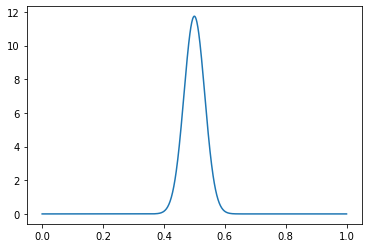

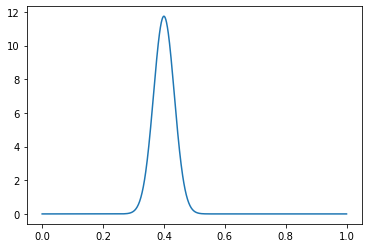

In [2]:
%matplotlib inline
# Create Earth 1D domain
EarthDomain = HyperParalelipiped(bounds=[[0,1]], 
                                          fineness=1000)
# Create our own sensitivity kernels
vs_sensitivity_kernels = [Gaussian_1D(domain=EarthDomain, center=0.5, width=0.2)]
vp_sensitivity_kernels = [Gaussian_1D(domain=EarthDomain, center=0.4, width=0.2)]
plt.figure(101)
for kernel in vs_sensitivity_kernels:
    plt.plot(EarthDomain.mesh, kernel.evaluate(EarthDomain.mesh)[1])
plt.show()

plt.figure(102)
for kernel in vp_sensitivity_kernels:
    plt.plot(EarthDomain.mesh, kernel.evaluate(EarthDomain.mesh)[1])
plt.show()
plt.show()

Then we create the needed spaces. In this case both model spaces are the same so I will take some shortcuts by creating only one model space. I will make a more formal example later. This one will give the correct answers but it is a bit "hacky". 

In [3]:
# Create Model space
M = PCb(domain=EarthDomain)
# Create Data space (must know number of sensitivity kernels)
D = RN(dimension=1)
# Create Property space (must know number of target kernels)
no_targets = 100  # Number of targets we will use
P = RN(dimension=no_targets)

And the mappings. For the property mapping we also need to create some target kernels. We now need target kernels for both physical parameters.

In [4]:
# Create vs and vp Data mapping (must have the sensitivity kernels)
G_vs = IntegralMapping(domain=M, codomain=D, kernels=vs_sensitivity_kernels)
G_vp = IntegralMapping(domain=M, codomain=D, kernels=vp_sensitivity_kernels)

# Create Target kernels
width = 1000 # same units as domain (km here)
enquiry_points = np.linspace(EarthDomain.bounds[0][0], 
                             EarthDomain.bounds[0][1], 
                             no_targets) # these are the locations where we center our targets

vs_target_kernels = []
vp_target_kernels = []
for i in range(no_targets):
    vs_target_kernels.append(Gaussian_1D(domain=EarthDomain,
                               center=enquiry_points[i],
                               width=width))
    vp_target_kernels.append(Null_1D(domain=EarthDomain))
# You can also try to replace Gaussian_1D with Boxcar_1D or DGaussian_1D
T_vs = IntegralMapping(domain=M, codomain=P, kernels=vs_target_kernels)
T_vp = IntegralMapping(domain=M, codomain=P, kernels=vp_target_kernels)

Now we generate some fake true model and data

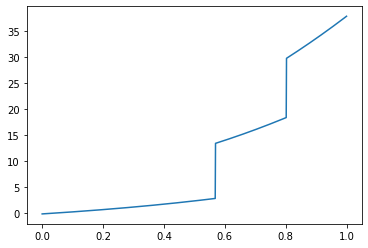

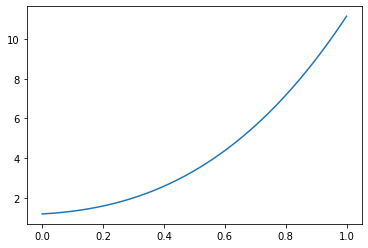

In [5]:
vs_true_model = Random_1D(domain=EarthDomain, seed=1)
vp_true_model = Random_1D(domain=EarthDomain, seed=2)
%matplotlib inline
vs_true_model.plot()
vp_true_model.plot()

data = G_vs.map(vs_true_model) + G_vp.map(vp_true_model)

Now we obtain the least norm solution

[[5.18069313]]


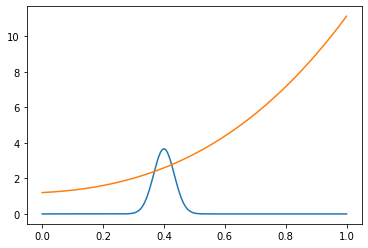

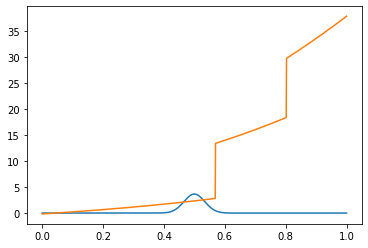

In [6]:
# Find pseudo-inverse
print(data)
G_vs_adjoint = G_vs.adjoint()
G_vp_adjoint = G_vp.adjoint()
# FiniteLinearMapping:
Lambda_vp = G_vp._compute_GramMatrix()
Lambda_vs = G_vs._compute_GramMatrix()
Lambda = Lambda_vp + Lambda_vs
# Now we invert Lambda
Lambda_inv = Lambda.invert()
# And finally find the least norm solution
least_norm_solution_vs = G_vs_adjoint.map(Lambda_inv.map(data))
least_norm_solution_vp = G_vp_adjoint.map(Lambda_inv.map(data))

# And we plot it
plt.plot(EarthDomain.mesh, 
         least_norm_solution_vp.evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, vp_true_model.evaluate(EarthDomain.mesh)[1])
plt.show()
plt.plot(EarthDomain.mesh, 
         least_norm_solution_vs.evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, vs_true_model.evaluate(EarthDomain.mesh)[1])
plt.show()

Now we want to compute the Resolving kernels. For this we need the X matrix: 

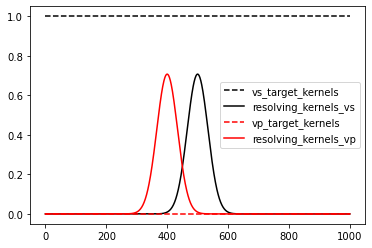

In [7]:
Gamma_vs = T_vs * G_vs_adjoint
Gamma_vp = T_vp * G_vp_adjoint
Gamma = Gamma_vp + Gamma_vs

X = Gamma * Lambda_inv
resolving_kernels_vs = np.dot(X.matrix, vs_sensitivity_kernels)
resolving_kernels_vp = np.dot(X.matrix, vp_sensitivity_kernels)
%matplotlib inline
# Choose which resolving kernel to plot below
which = 10
plt.figure(1)

# Plotting with legends
plt.plot(vs_target_kernels[which].evaluate(EarthDomain.mesh)[1], color='black', linestyle='dashed', label='vs_target_kernels')
plt.plot(resolving_kernels_vs[which].evaluate(EarthDomain.mesh)[1], color='black', linestyle='solid', label='resolving_kernels_vs')
plt.plot(vp_target_kernels[which].evaluate(EarthDomain.mesh)[1], color='red', linestyle='dashed', label='vp_target_kernels')
plt.plot(resolving_kernels_vp[which].evaluate(EarthDomain.mesh)[1], color='red', linestyle='solid', label='resolving_kernels_vp')

# Add legend
plt.legend()
plt.show()

And we compute the least norm solution property

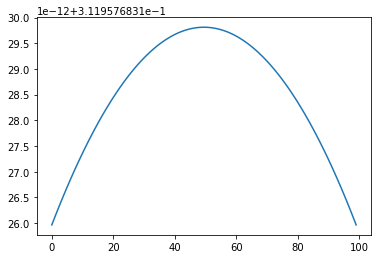

In [8]:
least_norm_property = X.map(data)

plt.plot(least_norm_property)

To compute the bounds we will need the diagonal of $\mathcal{H} = \chi - \Gamma \Lambda^{-1} \Gamma^*$ matrix, which are simply $\int (T_i - A_i)^2$ and a norm Bound $M$. Let's start by computing a norm bound using piecewise functions.

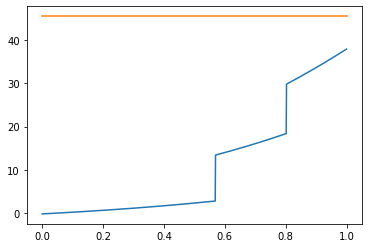

45.472626300315625 0.8989312334207759


In [9]:
intervals = np.array([0,1000, 2000, 5000, EarthDomain.bounds[0][1]])
values = vs_true_model.evaluate(intervals[1:])[1] * 1.2
upper_bound_function = Piecewise_1D(domain=EarthDomain, 
                 intervals=intervals,
                 values=values)
plt.figure()
plt.plot(EarthDomain.mesh, vs_true_model.evaluate(EarthDomain.mesh)[1])
plt.plot(EarthDomain.mesh, upper_bound_function.evaluate(EarthDomain.mesh)[1])
plt.show()

norm_bound = M.norm(upper_bound_function)
least_norm = M.norm(least_norm_solution_vs)
print(norm_bound, least_norm)

In [10]:
bounds = []
for resolving, target in zip(resolving_kernels_vs, vs_target_kernels):
    H_diag = M.norm(target - resolving)
    bound = np.sqrt((norm_bound**2 - least_norm**2))*H_diag
    bounds.append(bound)
bounds = np.array(bounds).reshape((no_targets, 1))

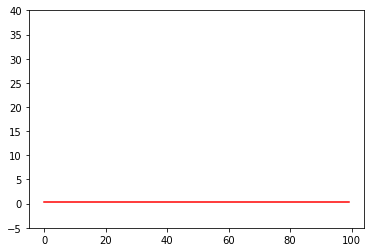

In [11]:
plt.figure(2)
plt.plot(least_norm_property - bounds, color='black')
plt.plot(least_norm_property, color='red')
plt.plot(least_norm_property + bounds, color='black')
plt.ylim(-5,40)
plt.show()